In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
 <a href="javascript:code_toggle()">expand</a>.''')

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.options.display.max_rows = 999
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices

In [3]:
FeatureTrain = pd.read_csv('./data/dengue_features_train.csv',parse_dates = ['week_start_date'])
TargetTrain = pd.read_csv('./data/dengue_labels_train.csv' )
FeatureTest = pd.read_csv('./data/dengue_features_test.csv',parse_dates = ['week_start_date'])
Answersheet = pd.read_csv('./data/submission_format.csv' )

#                                  Presentation Data Exploration

In [4]:
panel = TargetTrain.merge(FeatureTrain,on = ['city','year','weekofyear'] ,how = 'outer') 
 
kelvin = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',   \
          'reanalysis_max_air_temp_k','reanalysis_min_air_temp_k','reanalysis_dew_point_temp_k']
panel.loc[:,kelvin] = panel.loc[:,kelvin]-273.15# kelvin to C
FeatureTest.loc[:,kelvin] =FeatureTest.loc[:,kelvin]-273.15# kelvin to C
panel.columns
timeid = ['year', 'weekofyear']
green = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
precipitation  =['precipitation_amt_mm','reanalysis_sat_precip_amt_mm','station_precip_mm','reanalysis_precip_amt_kg_per_m2',]
avg_temp = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k',  'station_avg_temp_c' ]
min_temp = ['station_min_temp_c','reanalysis_min_air_temp_k']
max_temp = ['station_max_temp_c','reanalysis_max_air_temp_k']
dtr =  ['reanalysis_tdtr_k', 'station_diur_temp_rng_c']
humid = ['reanalysis_dew_point_temp_k','reanalysis_specific_humidity_g_per_kg', 'reanalysis_relative_humidity_percent']
selected = humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green + ['city','total_cases','week_start_date']
features_selected= humid + dtr + max_temp +min_temp +avg_temp +precipitation +timeid+green  
panel = panel.loc[:,selected]

 
 
 

In [5]:
city_name = 'sj'
def get_data_panel(panel,city_name):
    panel_train =  panel.loc[panel.city == city_name].fillna(method ='ffill') \
    .set_index('week_start_date').copy().drop(['city'],axis = 1).copy()
    
    panel_test = FeatureTest.loc[FeatureTest.city == city_name].fillna(method ='ffill') \
    .set_index('week_start_date').copy().drop('city',axis = 1)
    panel_test['total_cases'] = np.nan 
    train_len = len(panel_test['total_cases'])
    panel = pd.concat([panel_train,panel_test],sort = False).fillna(method ='ffill')
    
    
    panel['green_s']  = panel.loc[:,green[:2]].mean(1)
    panel['green_n']  = panel.loc[:,green[2:]].mean(1) 
    panel['green']  = panel.loc[:,green ].mean(1) 

    panel  = panel 
    return panel,train_len

panel_sj,len_sj = get_data_panel(panel,'sj') 
panel_iq,len_iq = get_data_panel(panel,'iq') 

def min_max(data):
     
    return (data - data.min())/(data .max()- data.min())
    

## Discribe data
 
#### 1. Target: reported total cases  Dengue fever cases weekly
#### 2. Features:
    1. Weekly Climate / environment data for San Juan(SJ) and Iquitos(IQ)
    2. Data can be catigorized by temperature(min/max/average), humidity,temperature range, precipitation
      and vagitation
    3. There are two schools (reanalysis(Theory recalculated) and measurement) for one climate variable.They are similar some even 
      duplicated. 

In [6]:
panel_sj.isnull().sum()

reanalysis_dew_point_temp_k              0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_relative_humidity_percent     0
reanalysis_tdtr_k                        0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
reanalysis_max_air_temp_k                0
station_min_temp_c                       0
reanalysis_min_air_temp_k                0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
station_avg_temp_c                       0
precipitation_amt_mm                     0
reanalysis_sat_precip_amt_mm             0
station_precip_mm                        0
reanalysis_precip_amt_kg_per_m2          0
year                                     0
weekofyear                               0
ndvi_ne                                  0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
total_cases                              0
green_s    

#### 3. dataset:
    1. For SJ, Train/Test(for submission) size is 936/260.(1990/04/30 - 2008/04/22 and 2008/04/29 - 2013/04/23) 
    2. For IQ, Train/Test(for submission) size is 520/156.(2000/07/01 - 2010/06/25 and 2010/07/02 - 2013/06/25)
    4. Missing values:there are many Nan values for green index and several others, fillna using KNN/interpolate/forward fill/group mean. Choose forward fill

## Explore data

Targets(Cont.):
    1. They are differed in scale and have some overlapping in time 
    2. First 60 data for IQ are 0, it is considered very from other observations
    3. The plots show strong seasonality. Peaks are much higher than usual values.-  detrend/deseason might need to be done
    4. For long term trend: SJ is decrease in scale while IQ is incrasing. This might relate to population informations

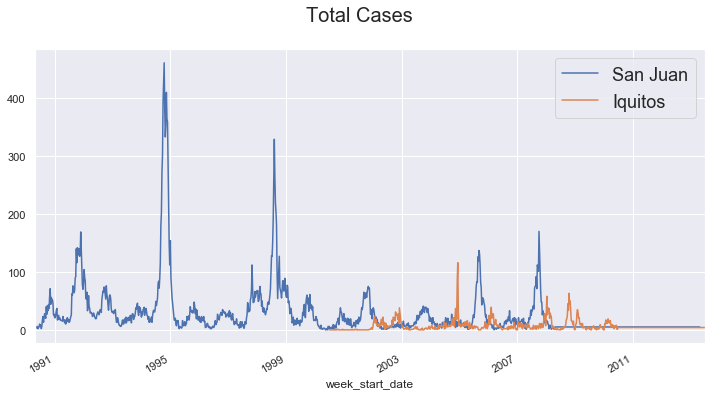

In [7]:
 
fig = plt.figure(figsize = (12,6) )
fig.suptitle('Total Cases', fontsize=20)
panel_sj.total_cases .plot( )
panel_iq .total_cases .plot()
plt.legend(['San Juan','Iquitos'],fontsize = 18)


### Vagitation:
    1. For SJ vagitation in the south are similar. while for IQ they are highly correlated, in this case I will take avarge of them 
      to reduce dimentions
    2. IQ's ndvi shows seasonality correspinding to the seasonality of total cases. Though higher peak doesn't indicate an out        break
    
    
    
    

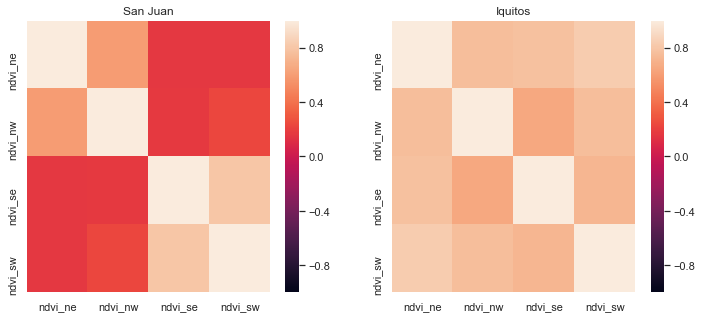

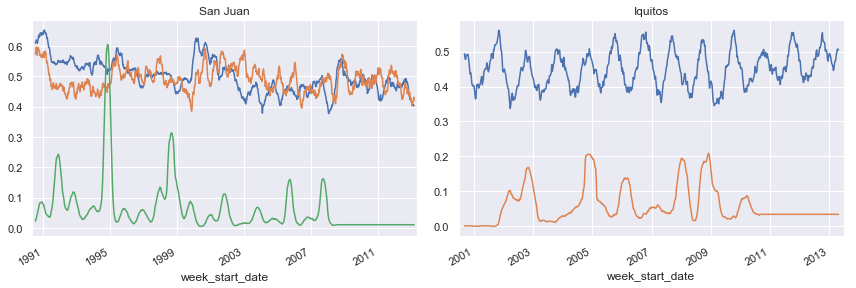

In [8]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,green].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,green].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')


 


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,green[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
min_max(panel_sj).loc[:,green[2: ]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
cases = ((min_max(panel_sj).loc[:,'total_cases']  )  ).rolling(20,center = True).mean()
cases =( cases  )
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,green].mean(1).rolling(20,center = True) .mean()  .plot(ax =axes[1])
cases = ((min_max(panel_iq).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
cases =( cases  )
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### precipitation
    1. The seasonality of precipitation actually predict quite well that of total cases'.  
    2. Two identical features are identified 
    3. There is counter example in 1995 for San Juan, using this sample may produce negtive impack, should we remove this time period?

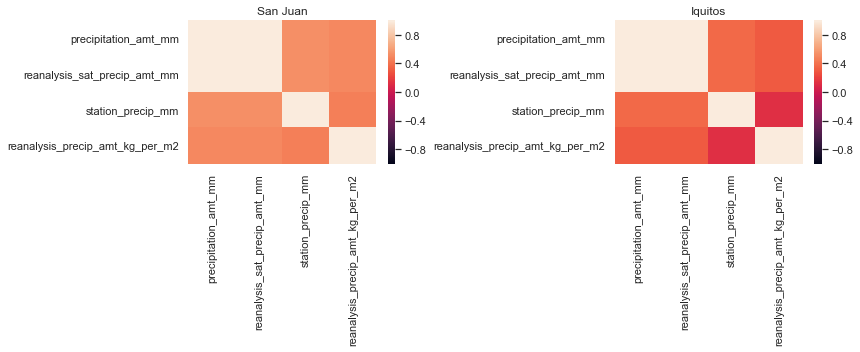

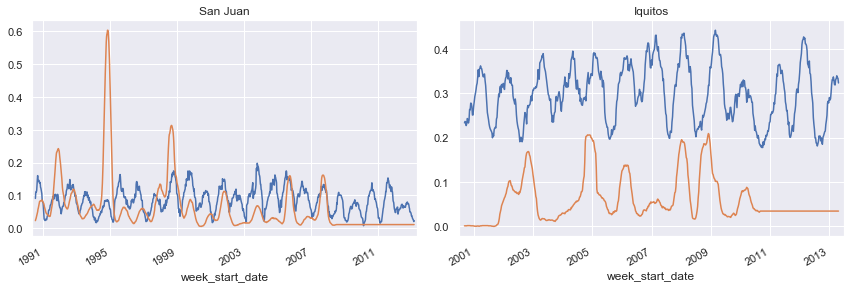

In [9]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,precipitation].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,precipitation].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
 


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,precipitation[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[0])
cases = ((min_max(panel_sj).loc[:,'total_cases']  )  ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,precipitation[:2]].mean(1).rolling(20,center = True).mean() .plot(ax =axes[1])
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Humidity: Specific humidity and dew point temperature are almost the same

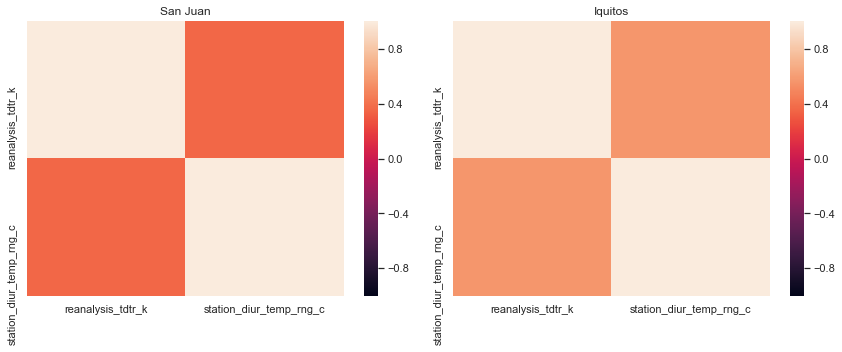

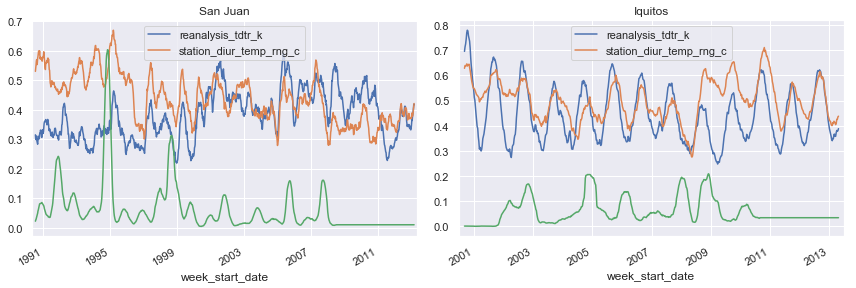

In [10]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,dtr].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,dtr].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
 


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,dtr ] .rolling(20,center = True).mean() .plot(ax =axes[0])
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,dtr ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

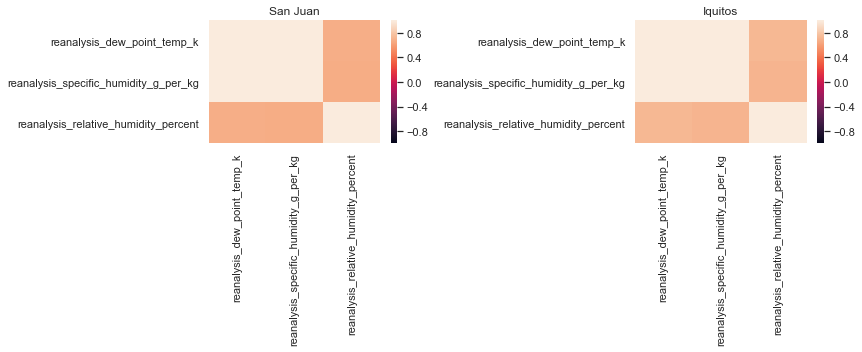

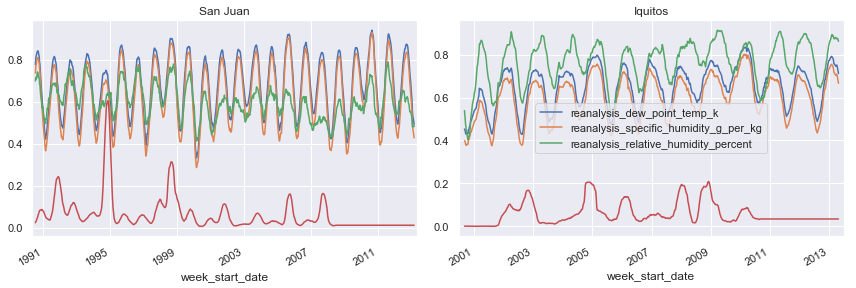

In [11]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,humid].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,humid].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()



"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,humid ] .rolling(20,center = True).mean() .plot(ax =axes[0],legend = False)
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0],legend = False)




min_max(panel_iq).loc[:,humid ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Strong seasonality in temperature

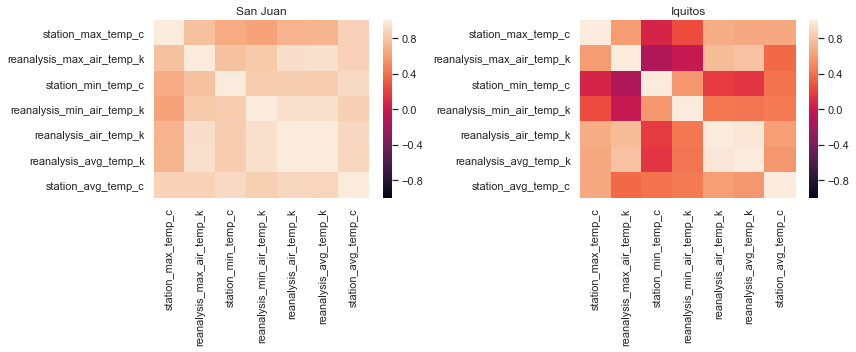

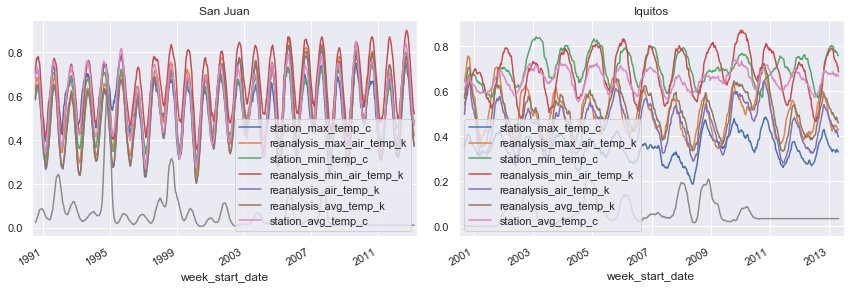

In [12]:
"""
1. For San Juan 

""" 
f, axes = plt.subplots(1, 2,figsize = (12,5))
sns.heatmap(min_max(panel_sj).loc[:,max_temp + min_temp + avg_temp].corr(),vmin = -1, vmax = 1,ax =axes[0] )
sns.heatmap(min_max(panel_iq).loc[:,max_temp + min_temp + avg_temp].corr(),vmin = -1, vmax = 1,ax =axes[1])

axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

plt.tight_layout()
 


"""
Trend
"""
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj).loc[:,max_temp + min_temp + avg_temp ] .rolling(20,center = True).mean() .plot(ax =axes[0])
 
cases = ((min_max(panel_sj).loc[:,'total_cases']  )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq).loc[:,max_temp + min_temp + avg_temp ] .rolling(20,center = True).mean() .plot(ax =axes[1])
 
cases = ((min_max(panel_iq).loc[:,'total_cases']   )   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Why model two city seperately? 
    Patten of SJ and IQ are quiet different(Different trend, seasonality, peaks)
### How to model seasonality ?
    Pattern of seasonality: Yearly. For most of the features, they seems to have the same half life, same magnitude of peak and valley(A sin(wt + theta) + B)
    
### How to model seasonality ?
    Pattern of seasonality: Yearly. For most of the features, they seems to have the same half life, same magnitude of peak and valley(A sin(wt + theta) + B)    


  
    

# De - Seasonality
    Y ~ A sin + B cos + C

In [13]:
series = panel_sj.loc[:,'total_cases']
def de_season_tri(series):
    
    target = series.name
    series = pd.DataFrame(series.copy())
    series["season_sin"] = np.sin(series.index.weekofyear/53*6.2831)
    series["season_cos"] = np.cos(series.index.weekofyear/53*6.2831)


    X_out = series.drop(target,axis = 1) 
    X_out  = sm.add_constant(X_out) 




    train_df = series.rolling(10,center = True).mean().dropna()
    train_y = train_df  .loc[:,target]
    train_y =train_y.clip(train_y.quantile(0.05),train_y.quantile(0.95))
    train_X = train_df  .drop(target,axis = 1)
    train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y,train_X)
    res = model.fit()
    return  series.loc[:,target] .ravel()/res  .predict(X_out) .ravel() - 1

def get_season_tri(series):
    
    target = series.name
    series = pd.DataFrame(series.copy())
    series["season_sin"] = np.sin(series.index.weekofyear/53*6.2831)
    series["season_cos"] = np.cos(series.index.weekofyear/53*6.2831)


    X_out = series.drop(target,axis = 1) 
    X_out  = sm.add_constant(X_out) 




    train_df = series.rolling(10,center = True).mean().dropna()
    train_y = train_df  .loc[:,target]
    train_y =train_y.clip(train_y.quantile(0.05),train_y.quantile(0.95))
    train_X = train_df  .drop(target,axis = 1)
    train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y,train_X)
    res = model.fit()
    return  res  .predict(X_out) .ravel()


panel_sj_ds = panel_sj.apply(de_season_tri,axis = 0)
panel_iq_ds = panel_iq.apply(de_season_tri,axis = 0)

D:\Anaconda3\envs\interview_env\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


##  After de-seasoning, there seems to be some patterns

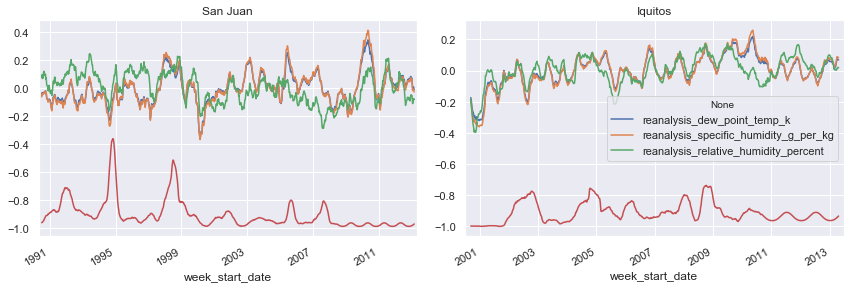

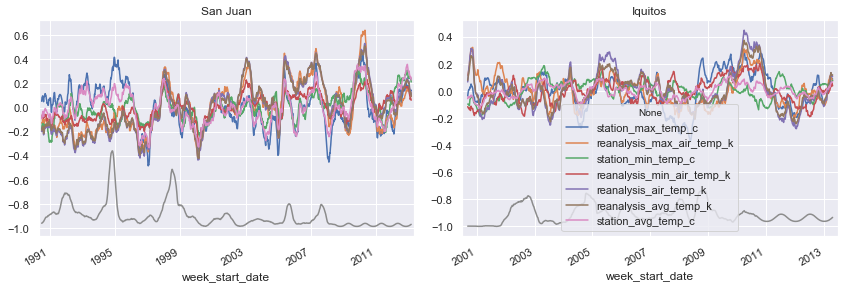

In [14]:
"""
See how it goes after de-season
max_temp + min_temp + avg_temp 
humid
green
precipitation
dtr
"""
from matplotlib.font_manager import FontProperties
 
 


selected_features = humid
f, axes = plt.subplots(1, 2,figsize = (12,4) )
 
min_max(panel_sj_ds).loc[:,selected_features ] .apply(de_season_tri,axis = 0).rolling(20,center = True).mean()  .plot(ax =axes[0], legend=False ) 

cases = ((min_max(panel_sj_ds).loc[:,'total_cases']  ) -1   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq_ds).loc[:,selected_features  ] .apply(de_season_tri,axis = 0).rolling(20,center = True).mean()  .plot(ax =axes[1] )
plt.legend(loc='best')
cases = ((min_max(panel_iq_ds).loc[:,'total_cases']   ) -1   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')



selected_features = max_temp + min_temp + avg_temp 
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj_ds).loc[:,selected_features ] .apply(de_season_tri,axis = 0).rolling(20,center = True).mean()  .plot(ax =axes[0], legend=False) 
 
cases = ((min_max(panel_sj_ds).loc[:,'total_cases']  ) -1  ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq_ds).loc[:,selected_features  ] .apply(de_season_tri,axis = 0).rolling(20,center = True).mean()  .plot(ax =axes[1], legend=False)
 
cases = ((min_max(panel_iq_ds).loc[:,'total_cases']   ) -1   ).rolling(20,center = True).mean()
plt.legend(loc='best') 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

### Take a closer Look

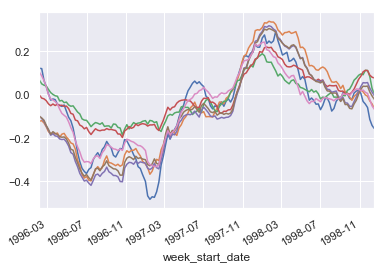

In [15]:
min_max(panel_sj_ds).loc[:,selected_features ] .apply(de_season_tri,axis = 0).rolling(20,center = True).mean() .iloc[300:450] .plot( legend = False) 
 

### Take differences

### Is gradient matter?

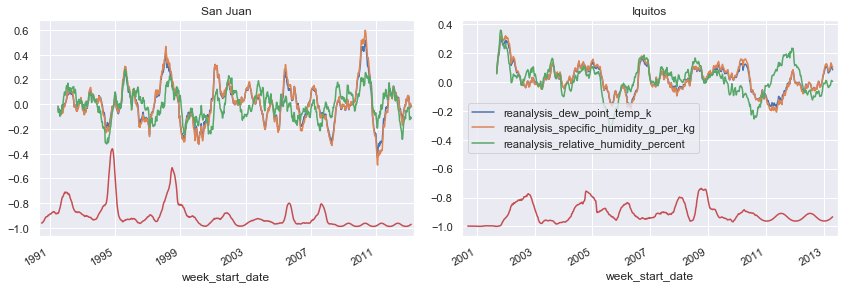

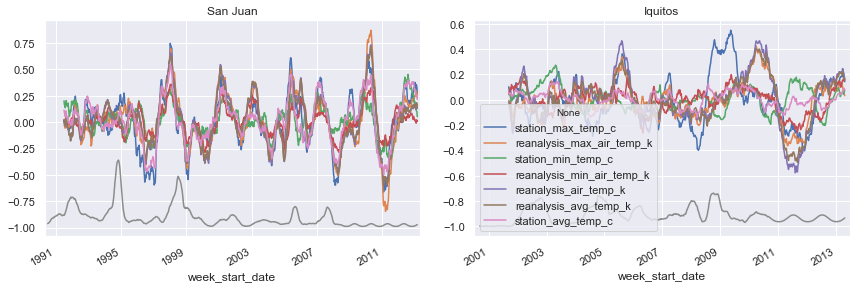

In [28]:
"""
See how it goes after de-season
max_temp + min_temp + avg_temp 
humid
green
precipitation
dtr
"""
from matplotlib.font_manager import FontProperties
 
 


selected_features = humid
f, axes = plt.subplots(1, 2,figsize = (12,4) )
 
min_max(panel_sj_ds).loc[:,selected_features ] .apply(de_season_tri,axis = 0).\
rolling(20,center = True).mean().diff(52) .plot(ax =axes[0], legend=False) 
cases = ((min_max(panel_sj_ds).loc[:,'total_cases']  ) -1   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq_ds).loc[:,selected_features ] .apply(de_season_tri,axis = 0).\
rolling(20,center = True).mean().diff(52) .plot(ax =axes[1] ) 
cases = ((min_max(panel_iq_ds).loc[:,'total_cases']   ) -1   ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')



selected_features = max_temp + min_temp + avg_temp 
f, axes = plt.subplots(1, 2,figsize = (12,4))
min_max(panel_sj_ds).loc[:,selected_features ] .apply(de_season_tri,axis = 0).\
     rolling(20,center = True).mean().diff(52) .plot(ax =axes[0], legend=False) 
 
cases = ((min_max(panel_sj_ds).loc[:,'total_cases']  ) -1  ).rolling(20,center = True).mean()
 
cases .plot(ax =axes[0])




min_max(panel_iq_ds).loc[:,selected_features  ] .apply(de_season_tri,axis = 0).\
rolling(20,center = True).mean() .diff(52).plot(ax =axes[1], legend=False) 
cases = ((min_max(panel_iq_ds).loc[:,'total_cases']   ) -1   ).rolling(20,center = True).mean()
plt.legend(loc='best') 
cases .plot(ax =axes[1])

plt.tight_layout()
axes[0].title.set_text('San Juan')
axes[1].title.set_text('Iquitos')

## Build Models

### Feature Selection
1. PCA or avaraging for factor in the same group to reduce dimentionality, and then run it through models
2. Tries LASSO regression/Ridge for feature selections: Poor fit and doesn't show improvement
3. Try out all the interaction terms(product between variabls)
4. Use Tree method to brute force select variables, works

### What types of model ?
    There is not any apparent linear realationship between factor and total cases beside from seasonality. We might need to consider some some ensamble methods(It turns out random forest and XGB are the best among KNN/GLM//LSTM)
### Parameter choice
    Given the noise in the data, we need to regularize the model more.
### Time Dependency
    3. Each observation is highly depends on the previos one. But in the testing set, we don't have passed observations. LSTM seems to adress this issure but passing the memories. It will be an interesting teritory to be explored
    
### Pattern Shifting with Time
    Use later part to fit the data and vailidate on first part give a low score(For San Juan 33+)
    Use previous part to fit and validate on later part give a better score(17 +)
    We can also see the patterns are quite different, while for later part, seasonality take the most parts(Thus easier to predict)
    Boostrapping sample/features to train model will help in this issue

## Modling Approches
     Based on our analysis from EDA, we can learn:
         1. The series pattern is seasonaland autoarresive with trend and jump
         2. No any indivdual factor shows high correlation for prediction the series other than seasonality
         3. Time span is very long, magnitude also changing with time.
     Approaches:
         1. Predict seasonal adjust series and re-scaled the prediction series
         2. Directly predict original series 
     Model:
         1. Random forest with boostrapping 
         2. Grandient Boost 
         3. GLM model with parsimonious inputs
         4 .LSTM with parsimonious inputs
    So there are 8 models in total  X  2 approaches
    Finally, we avarage all models for the final output. 

Best Results

## Brute Force Feature selection: Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

drops = ['reanalysis_specific_humidity_g_per_kg']  + green +\
['reanalysis_sat_precip_amt_mm','reanalysis_avg_temp_k','year','weekofyear','total_cases'] 
 
panel_sj_selected  = panel_sj.loc[:,['total_cases']]
panel_iq_selected  = panel_iq.loc[:,['total_cases']] 

 

def append_shift(left,right,selected,shift,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(x.quantile(0.05),x.quantile(0.95)),axis = 0)
    for name in selected:
        new_name = name + '_shift_' +str(shift)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth     ).mean().shift(shift).loc[:,name ]
    return left

def append_diff(left,right,selected,diff,smooth =52):
    new_names = []
    right = right.copy().apply(lambda x : x.clip(x.quantile(0.05),x.quantile(0.95)),axis = 0)
    for name in selected:
        new_name = name + '_diff_' +str(diff)+'_smooth_' + str(smooth)
        new_names.append(new_name)
 
        left[new_name] = right.rolling(smooth   ).mean().diff(diff).loc[:,name ]
    return left
 
def de_season_tri(series):
    
    target = series.name
    series = pd.DataFrame(series.copy())
    series["season_sin"] = np.sin(series.index.weekofyear/53*6.2831)
    series["season_cos"] = np.cos(series.index.weekofyear/53*6.2831)


    X_out = series.drop(target,axis = 1) 
    X_out  = sm.add_constant(X_out) 




    train_df = series.dropna()
    train_y = train_df  .loc[:,target]
    train_y =train_y.clip(train_y.quantile(0.05),train_y.quantile(0.95))
    train_X = train_df  .drop(target,axis = 1)
    train_X = sm.add_constant(train_X)
    model = sm.OLS(train_y,train_X)
    res = model.fit()
    return  series.loc[:,target] .ravel()/res  .predict(X_out) .ravel() - 1


 
def data_process(panel,panel_candidate ):
    
    """
    Make sure it is at least forward filled
    """
    choises = ['reanalysis_dew_point_temp_k','reanalysis_precip_amt_kg_per_m2','station_avg_temp_c'] 

    panel = append_shift(panel,panel_candidate,\
         choises,0,52)
    
    panel = append_shift(panel,panel_candidate,\
         choises,0,10)
    
    panel = append_diff(panel,panel_candidate,\
          choises,1,52)
    
    
    # de - seasons
    de_seasons = panel_candidate.apply(de_season_tri,axis = 0)
    new_names = [name +'_ds' for name in de_seasons.columns]
    de_seasons.columns = new_names
    
 
    panel = append_shift(panel,de_seasons,\
         de_seasons.columns,0,52)
    
    panel = append_shift(panel,de_seasons,\
         de_seasons.columns,0,10)
    
    panel = append_diff(panel,de_seasons,\
          de_seasons.columns,1,52)
 
    return panel .fillna(method = 'ffill')



panel_sj_selected =  data_process(panel_sj_selected,panel_sj.drop(drops,axis = 1))
panel_iq_selected =  data_process(panel_iq_selected,panel_iq.drop(drops,axis = 1)) 


train_y_sj, train_X_sj =   panel_sj_selected  .iloc[: -len_sj].dropna().loc[:,'total_cases'],\
                            panel_sj_selected .iloc[: -len_sj] .dropna().drop('total_cases',axis = 1)  
 
train_y_iq, train_X_iq =   panel_iq_selected .iloc[60: -len_iq].dropna() .loc[:,'total_cases'],\
                            panel_iq_selected.iloc[60: -len_iq] .dropna() .drop('total_cases',axis = 1)  
                         

test_X_sj = panel_sj_selected.drop('total_cases',axis = 1)  .iloc[-len_sj: ]
test_X_iq = panel_iq_selected.drop('total_cases',axis = 1)  .iloc[-len_iq: ]





### Random Forest: 21.7

In [30]:
rf_sj = RandomForestRegressor(n_estimators=400,  
                                         max_depth=6, criterion='mae',min_samples_leaf = 0.05,  max_features='auto', warm_start=True, \
                                )
rf_sj.fit( train_X_sj ,train_y_sj.clip(0,250) )
rf_iq = RandomForestRegressor(n_estimators=400, max_features='auto',
                                         max_depth=6, criterion='mae', min_samples_leaf = 0.05, warm_start=True)

rf_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))




RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.05,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=True)

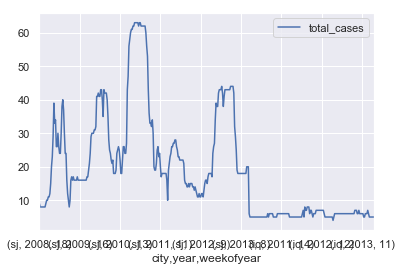

In [31]:

sj_predictions =  pd.Series(np.round(rf_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(rf_iq .predict(test_X_iq )).astype(int) )  

 
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_rf.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot() 

###  Feature importances for SJ(Top 50)

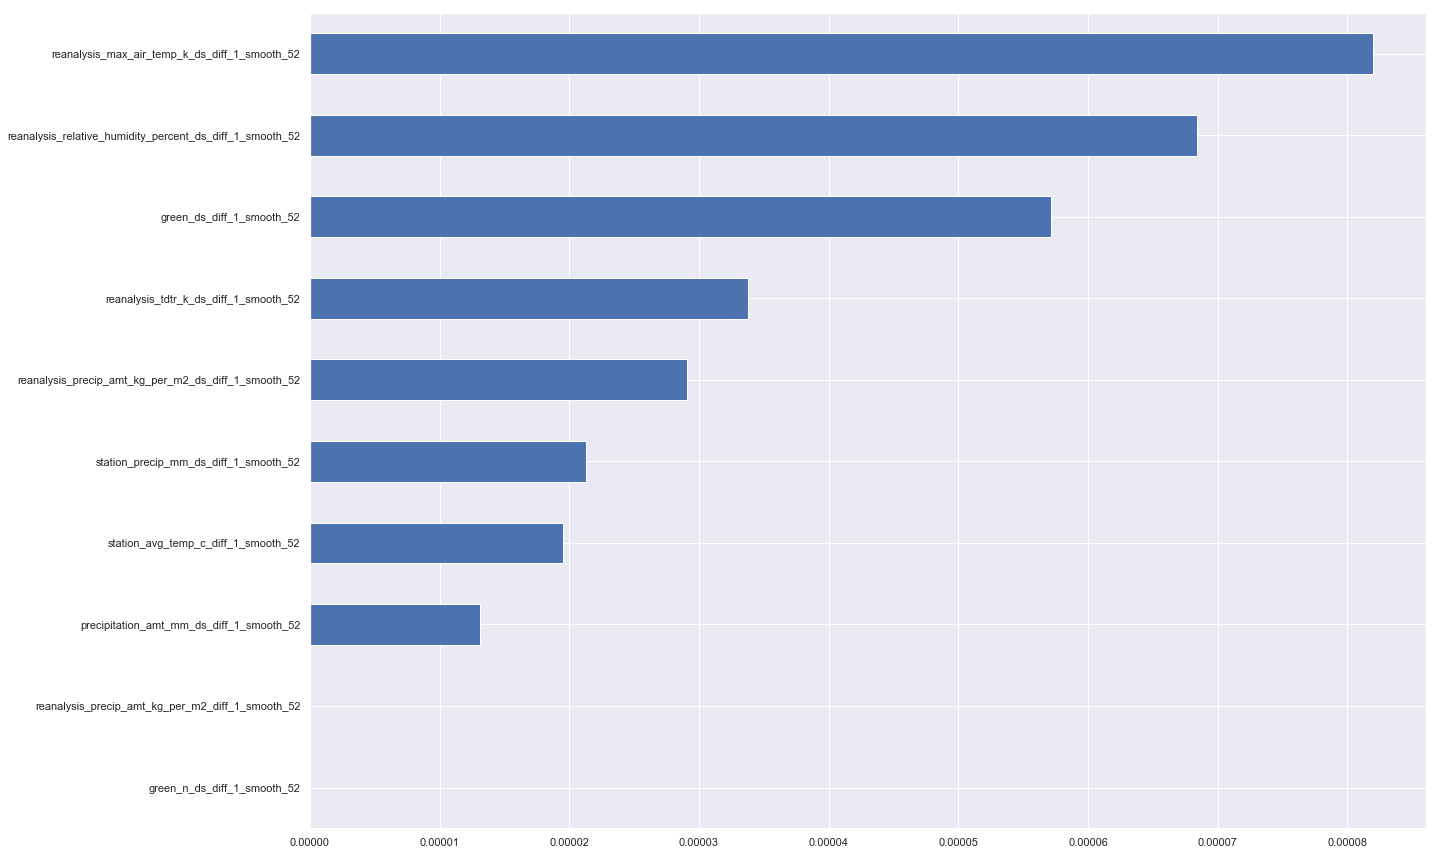

In [38]:
plt.figure(figsize = (20,15))
pd.Series(rf_sj.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:10].plot.barh()

###  Feature importances for IQ (Top 50)

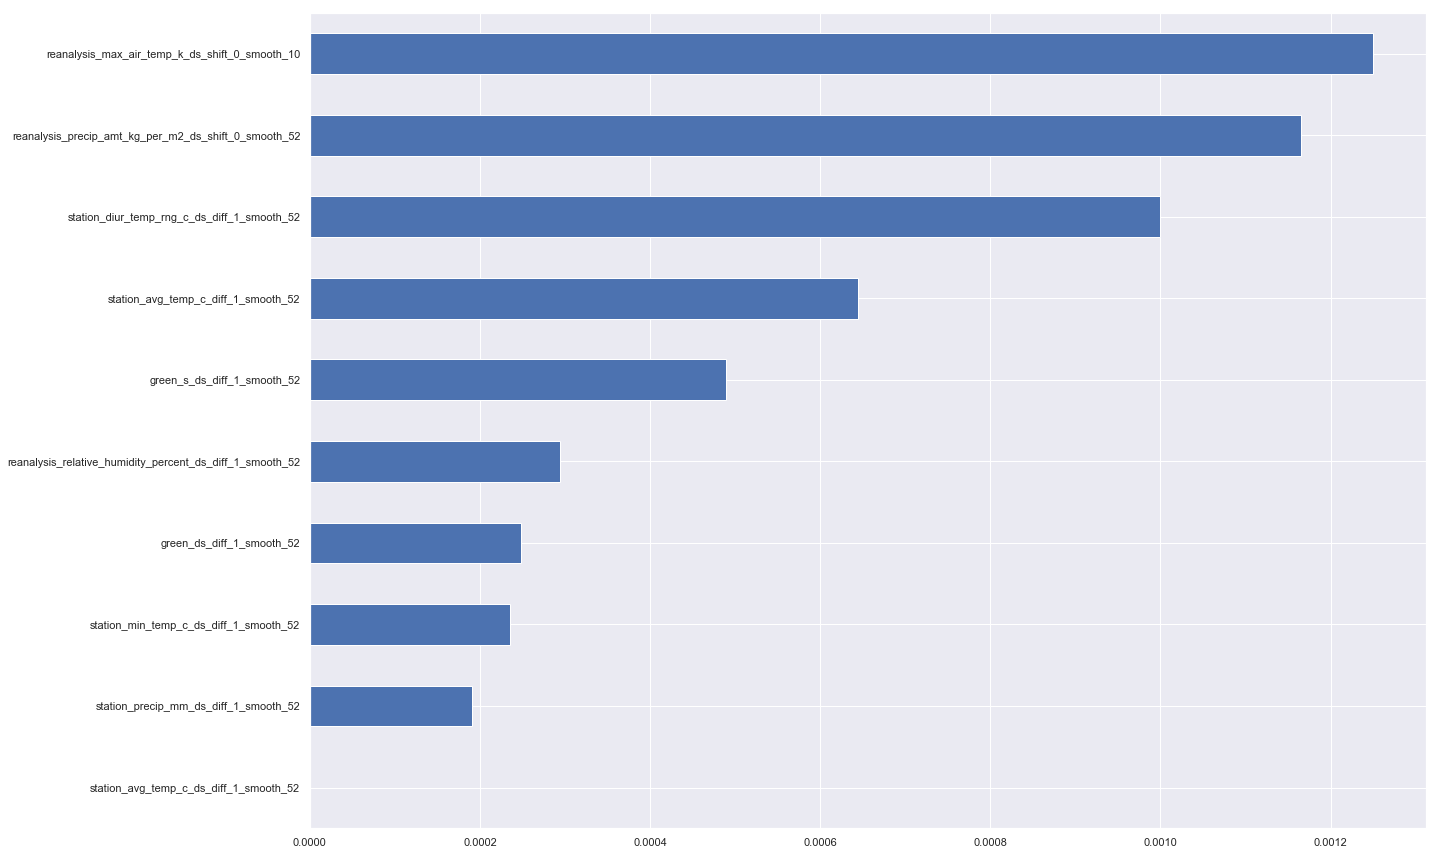

In [37]:
plt.figure(figsize = (20,15))
pd.Series(rf_iq.feature_importances_,index = train_X_sj.columns).sort_values(ascending = True).iloc[:10].plot.barh()

## XGBoost:23.51

D:\Anaconda3\envs\interview_env\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


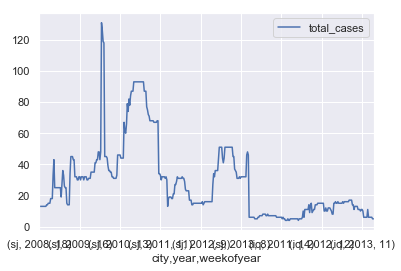

In [34]:
from xgboost import XGBRegressor
 
 
 
xgb_sj = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None,  
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)


xgb_sj.fit( train_X_sj ,train_y_sj.clip(0,250) )


xgb_iq = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None,  
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

xgb_iq.fit(train_X_iq  ,train_y_iq.clip(0,40))


sj_predictions =  pd.Series(np.round(xgb_sj . predict( test_X_sj)).astype(int) ) 
iq_predictions =  pd.Series(np.round(xgb_iq .predict(test_X_iq )).astype(int) ) 

 
def submission( sj_predictions,iq_predictions):
    sj_predictions =  pd.Series(np.round(sj_predictions  ).round().astype(int) )
    iq_predictions =  pd.Series(np.round(iq_predictions )  .round().astype(int) )
    submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
    submission.total_cases =np.concatenate([sj_predictions, iq_predictions])
   
    submission.to_csv("./data/submission_xgb.csv")
    return submission
    
submission(sj_predictions ,iq_predictions).plot() 

## Ensamble:21.25

In [35]:
xgb_pred = pd.read_csv("./data/submission_xgb.csv",index_col = [0,1,2])
rf_pred = pd.read_csv("./data/submission_rf.csv",index_col = [0,1,2])
ens_pred = np.round((xgb_pred+rf_pred)/2).astype(int)
ens_pred.to_csv("./data/submission_esb.csv")

### GLM